# Python final project——戴明伟老师

- 姓名：白一博
- 专业：统计学
- 学号：219020208019

# 线性模型$y_{N \times 1} = X_{N \times M}\beta + e$ 
1. 随机变量$\beta, e$服从分布 $\beta \sim N(0, \sigma^2_{\beta}\mathrm{I}_M), e \sim N(0, \sigma^2_e \mathrm{I}_N)$
2. X 为design matrix, 考虑两种生成方式 (a)X的每一列独立且服从标准正态分布 (b)简单模拟基因数据(相近的基因变异点可能存在相关性，此处暂不考虑), 每一列都是0, 1, 2的组合,  每一列参考的位点(A(T)或G(C))的数目占总数(N)的比例假设服从（0.51, 0.95]均匀分布 <font color = "red">A(T)数目较多，则A(T)是参考位点，反之亦然，所以假设它的最小比例为0.51,但同时另外一种位点数目不能过少，不能小于0.05</font>
3. 给定N, M, $r = \frac{var(X\beta)}{var(e)}$和对X的要求, 生成满足条件的模拟数据

# 要求和提示
1. 为有效地代码复用以及良好的可扩展性(X可能有新的约束条件)，用面向对象的思想设计类.
2. 温馨提示：
   <font color = "red">对于目前题目的要求，最终需要生成两个问题类，不妨称为连续问题类 CProlem和离散问题类 DProblem, 这两个问题都需要由N, M ,r 来构造, 生成满足条件的问题对象.</font>
   需要思考CProbelm和DProblem需要一些什么样的数据成员便于使用
3. <font color = "blue">提交时间：15周上机课之后</font>
4. 有任何疑问欢迎去信 daimw@swufe.edu.cn 沟通交流

In [5]:
from itertools import product
from sklearn.linear_model import RidgeCV, BayesianRidge, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pickle
import os

In [6]:
class problem:
    def __init__(self, beta, N, M, r):
        '''
        beta: 生成的beta
        M: X的列
        N: X的行
        R: 信噪比
        '''
        self.N = N
        self.M = M
        self.r = r
        self.beta = beta
        self.error = None
        self.xtest = None
        self.ytest = None
        self.xtrain = None
        self.ytrain = None
    
    #定义生成beta和error的函数，传入N和M为行列              
    def generate_error(self):
        #np.random.seed(self.random_state)#np.random.seed函数表示基于self.random_state这个种子随机生成可预测的随机数
                                           #可以保证部分参数（比如W权重参数）的随机初始化值相同

        #生成残差的均值、方差，并模拟生成残差
        error = np.random.normal(0, np.random.random(1), size=self.N)
        #将生成的beta和error reshape一下，1表示将其形状固定为只有一列
        error = error.reshape(-1, 1)
        self.error = error
    
    #定义计算y的函数            
    def y_val(self, X):
        Y = X @ self.beta + self.error

        return Y

In [7]:
import numpy as np

#生成一个X的每一列独立且服从标准正态分布
class C_problem(problem):
    def __init__(self, **param): 
        problem.__init__(self, **param)
        
    def generate_data_error(self):
        while True:  #由于不知道生成一个大于给定r的信噪比需要多少轮，所以不使用for循环
            self.generate_error()  #用到了base类中的生产beta和error的函数
            X = np.random.normal(0, 1, size=(self.N, self.M))
            xinzaobi = np.var(X @ self.beta) / np.var(self.error)   #求r的值
            if xinzaobi < self.r:   #判断生成的r和输入的r的大小关系
                continue
            else:
                break
        y = self.y_val(X)
        return X, y
    
#简单模拟基因数据生成X
class D_problem(problem): 
    def __init__(self, **param):
        problem.__init__(self, **param)
        
    def generate_data_error(self):
        while True:
            self.generate_error()  #用到了base类中的生产beta和error的函数

            AT = np.random.uniform(0.51, 0.95) #np.random.uniform函数从一个均匀分布[low,high)中随机采样，注意定义域是左闭右开，即包含low，不包含hig

            GC = 1 - AT   #这里有一个问题是0.51可能取到，但是在老师给出的要求中0.51不能取到
            AA, GG = AT**2, GC**2
            AG = (AT - AA) + (GC - GG)
            prob = np.array([AA, AG, GG])

            X = np.random.choice(3, size=(self.N, self.M), p=prob)  #随机生成0、1、2的尺寸服从N*M的，三个数存在概率为p这个概率矩阵

            xinzaobi = np.var(X @ self.beta) / np.var(self.error)
            if xinzaobi < self.r: 
                continue
            else:
                break
        y = self.y_val(X)
        return X, y

In [8]:
class Result_Save:
    # 写入时将结果赋值
    def __init__(self):
        self.results = None
    # 写入
    def save(self, path, results):
        with open(path, 'wb') as fo:
            pickle.dump(results, fo)
    # 读取，可以返回results
    def read(self, path):
        with open(path, 'rb') as fi:
            self.results = pickle.load(fi)
        
        return self.results

In [9]:
class Model_Predict:
    def __init__(self, type_, X, y, problem):
        if type_ == 'ridge':
            self.model = RidgeCV(cv=5)
        elif type_ == 'bayesianridge':
            self.model = BayesianRidge()
        elif type_ == 'elasticnet':
            self.model = ElasticNetCV(alphas=(0.0001, 0.0003, 0.001, 0.003, 0.01),cv=5)
            
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        self.xtest = X_test
        self.xtrain = X_train
        self.ytest = y_test
        self.ytrain = y_train
        
    
    def get_score(self):
        self.model.fit(self.xtrain, self.ytrain)
        y_pred = self.model.predict(self.xtest)
        mse_score = mean_squared_error(self.ytest, y_pred)
        r_2_score = r2_score(self.ytest, y_pred)
        return mse_score, r_2_score, self.model

In [10]:
def gengroups(**param):
    result=[]
    for key in param:
        result.append(param[key])
    return list(product(*result)) 

## 封装

In [16]:
class GenProblem:
    def __init__(self, type_, **param):
        """
        必须传入的
        keys = ['M', 'N', 'r', 'nSim', 'evaluation', 'type_']
        type_: continous/discrete
        """
        self.type_ = type_
        self.param = param
    
    def run(self):
        if self.type_ == 'continous':
            self.genproblems(C_problem, **self.param)
        elif self.type_ == 'discrete':
            self.genproblems(D_problem, **self.param)
    
    def genproblems(self, problem, nSim, evaluation, **param):
        """
        problem: problem类体，非初始化后的实例(C_problem:连续型; D_problem:离散型)
        nSim: 组数
        evaluation: 评价指标
        param：包含 m，n，r 等参数
        """
        # 创建一个空的文件夹
        if not os.path.exists('./temp_save'):
            os.mkdir('./temp_save')
            
            
        # nsim是组数 30、50组
        problemlist = list()
        param_result = gengroups(**param)
        param_result = [dict(zip(param.keys(), result)) for result in param_result]
        for para in param_result:
            for i in range(nSim):
                para['beta'] = np.random.normal(0, np.random.random(1), size=(para.get('M'),1))
                p = problem(**para) 
                problemlist.append(p)

        for pro, para in zip(problemlist, param_result):
            results = []
            key = 'M_{}N_{}r_{}nsim_{}_{}'.format(para.get('M'), para.get('N'), para.get('r'), nSim, problem.__name__)
            if not os.path.exists('./temp_save/{}.pkl'.format(key)):
                for i in range(nSim):
                    generator = pro
                    X, y = generator.generate_data_error()
                    result = {'X': X, 'y': y}
                    results.append(result)
            
                rs = Result_Save()
                rs.save('./temp_save/{}.pkl'.format(key), results)
                del results


        types = ['ridge', 'bayesianridge', 'elasticnet']
        problem_name = ''
        if problem.__name__ == 'C_problem':
            problem_name = 'C_problem'
            types = types[:2]
        elif problem.__name__ == 'D_problem':
            types = types[:]
            problem_name = 'D_problem'
            
        for problem, para in zip(problemlist, param_result): 
            key = 'M_{}N_{}r_{}nsim_{}_{}'.format(para.get('M'), para.get('N'), para.get('r'), nSim, problem_name)
            rs = Result_Save()
            results = rs.read('./temp_save/{}.pkl'.format(key))
            
            mse_scores_list = []
            r2_scores_list = []
            for type_ in types:
                mse_scores = []
                r2_scores = []
                for i in range(nSim):
                    X, y = results[i].get('X'), results[i].get('y')
                    mp = Model_Predict(type_, X, np.ravel(y), problem)
                    mse_score, r_2_score, model = mp.get_score() 
                    mse_scores.append(mse_score)
                    r2_scores.append(r_2_score)
                mse_scores_list.append(mse_scores)
                r2_scores_list.append(r2_scores)

            if evaluation == "r2_score":
                plt.boxplot(x = r2_scores_list, labels = types)
                # 添加y轴标签
                plt.ylabel('R2 Score')
                # 添加标题
                plt.title('N={},M={},R={}'.format(para.get('N'), para.get('M'), para.get('r')))
                # 显示图形
                plt.show()
            elif evaluation == "mse":
                plt.boxplot(x = mse_scores_list, labels = types)
                # 添加y轴标签
                plt.ylabel('Mean Squared Error')
                # 添加标题
                plt.title('N={},M={},R={}'.format(para.get('N'), para.get('M'), para.get('r')))
                # 显示图形
                plt.show()
            
            del results

## 用户输入

In [17]:
M = [10, 20]
N = [30, 40, 50]
r = [10, 20]
param = {'M': M, "N": N, 'r': r, 'evaluation': 'mse', 'nSim':20}

In [18]:
gen = GenProblem('continous', **param)

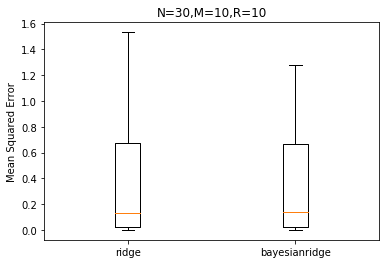

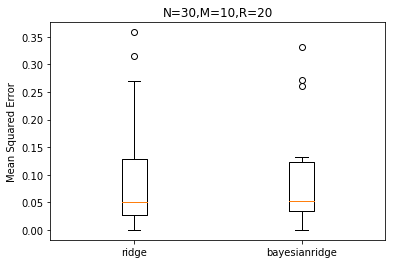

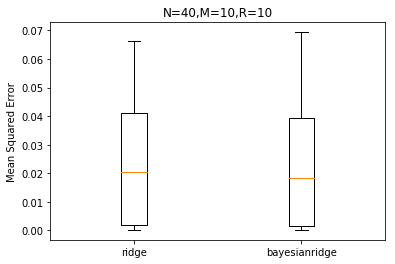

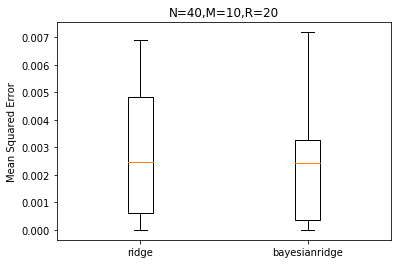

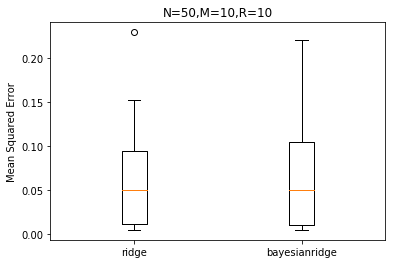

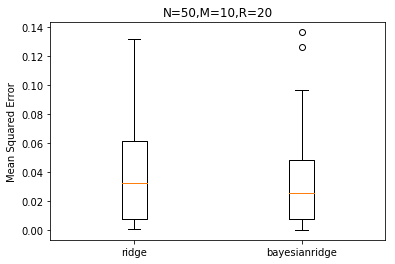

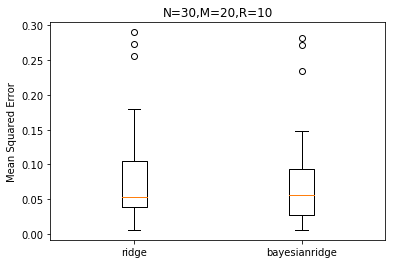

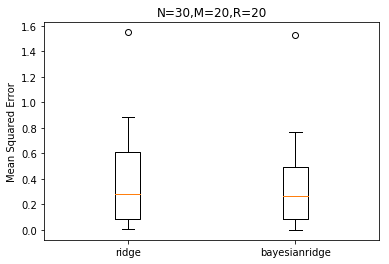

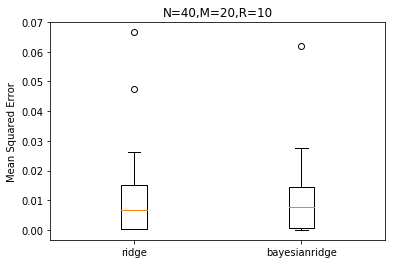

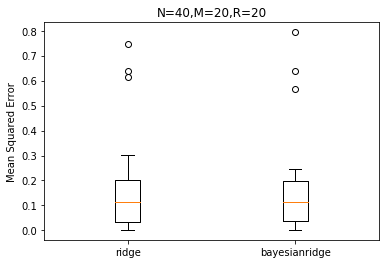

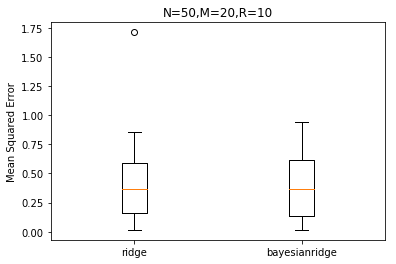

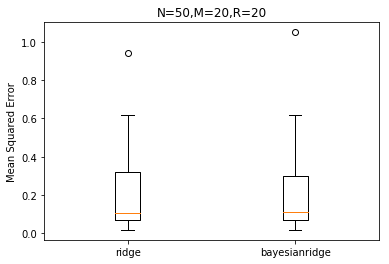

In [19]:
gen.run()

## 更改evalution和problem

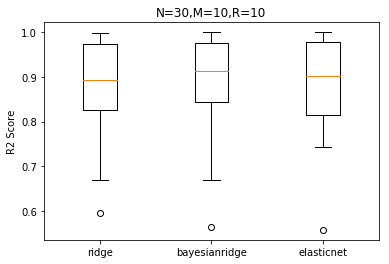

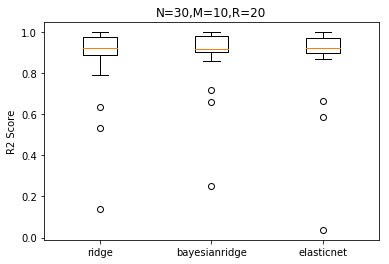

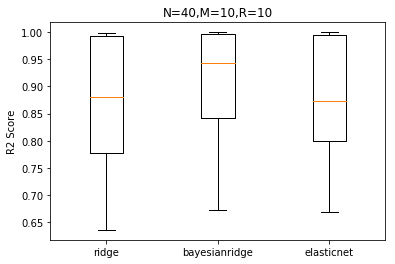

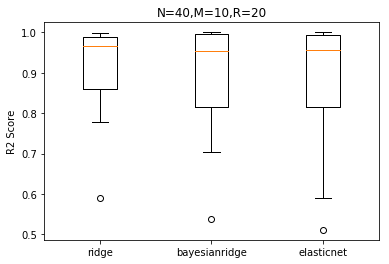

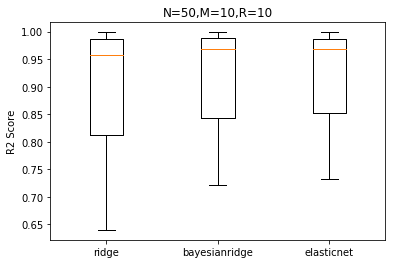

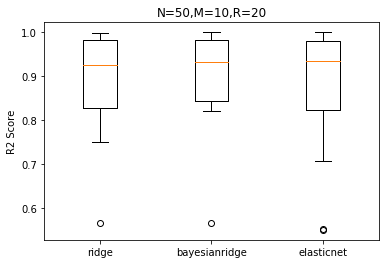

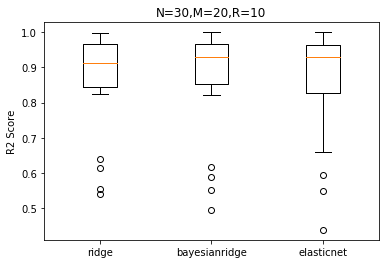

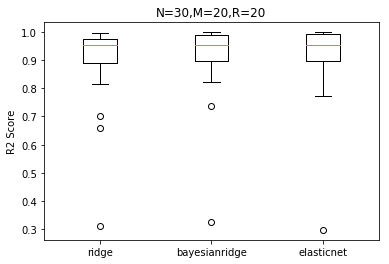

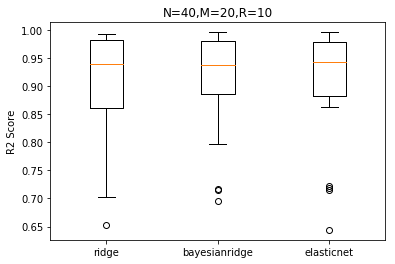

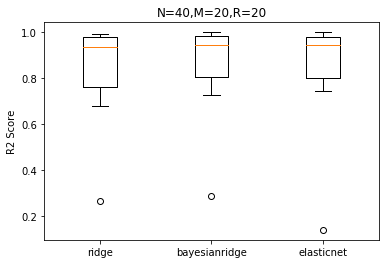

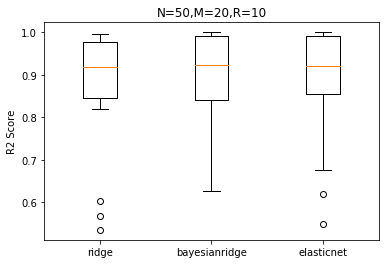

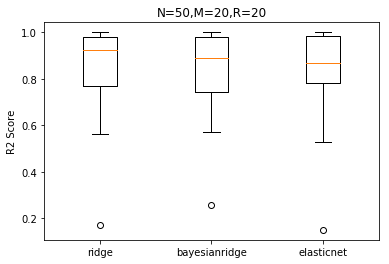

In [20]:
M = [10, 20]
N = [30, 40, 50]
r = [10, 20]
param = {'M': M, "N": N, 'r': r, 'evaluation': 'r2_score', 'nSim':20}
gen = GenProblem('discrete', **param)
gen.run()